<a href="https://colab.research.google.com/github/MarcoSteuri/music_speech_classification/blob/main/NN_sound_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import modules and load functions

In [1]:
# Source functions und Transformationen zu tensorflow dataset: https://github.com/jkcas22/music_speech/blob/main/RNN.ipynb

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
#from tensorflow.keras import regularizers
from scipy.signal import hann
from scipy.io import wavfile
	
def get_mag_phs(re_im):
    mag_phs=[]
    for c in re_im:
        re=c[0]
        im=c[1]
        mag_phs.append([np.sqrt(re**2 + im**2), np.angle(re + im * 1j)])
    return np.array(mag_phs)


def get_logmag(re_im):
    logmag=[]
    for c in re_im:
        re=c[0]
        im=c[1]
        logmag.append(np.log(np.sqrt(re**2 + im**2)))
    return np.array(logmag)


def get_re_im(mag_phs):
    re_im=[]
    for c in mag_phs:
        mag=c[0]
        phs=c[1]
        re_im.append([mag * np.cos(phs), mag * np.sin(phs)])
    return np.array(re_im)


def load_wav(filenames):
    wl=[]
    for name in filenames:
        _, w = wavfile.read(name)
        w = w.astype(np.float32)
        norm = np.max(np.abs(w))
        w = w / norm
        w -= np.mean(w)
        wl.append(w)
    return np.array(wl)


def dft(sounds, fft_chunks, fft_step=256, fft_size=512):
    #fft_chunks = len(sounds[0]) // fft_step
    hann_win = hann(fft_size)
    re_im = []
    for signal in sounds:
        s = []
        for i in range(fft_chunks):
            frame = signal[(i * fft_step):(i * fft_step + fft_size)]
            frame = np.pad(frame, (0, fft_size - len(frame)), 'constant')
            frame *= hann_win
            s.append(frame)
        s = np.array(s)
        N = s.shape[-1]
        k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [1, N // 2])
        x = np.reshape(np.linspace(0.0, N - 1, N), [N, 1])
        freqs = np.dot(x, k)
        reals = np.dot(s, np.cos(freqs)) * (2.0 / N)
        imags = np.dot(s, np.sin(freqs)) * (2.0 / N)
        re_im.append([reals,imags])
    return np.array(re_im)


def dft_logmag(sounds, fft_chunks, fft_step=256, fft_size=512):
    re_im = dft(sounds, fft_chunks, fft_step, fft_size)
    return get_logmag(re_im)


def idft(re, im, step_size=256, fft_size=512):
	N = re.shape[1] * 2
	k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [N // 2, 1])
	x = np.reshape(np.linspace(0.0, N - 1, N), [1, N])
	freqs = np.dot(k, x)
	signal = np.zeros((re.shape[0] * step_size + fft_size,))
	recon = np.dot(re, np.cos(freqs)) + np.dot(im, np.sin(freqs))
	for hop_i, frame in enumerate(recon):
		signal[(hop_i * step_size): (hop_i * step_size + fft_size)] += frame
	return signal

# Load files

In [2]:
#mount google drive when on google colab and set working directory
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/CAS/M6/Music_speech/')

working_dir = os.getcwd()
print(f'\nWorking directory: {working_dir}')

Mounted at /content/drive

Working directory: /content/drive/MyDrive/CAS/M6/Music_speech


In [3]:
#Load music
music_dir = './data/music_wav'
if not os.path.isdir(music_dir): 
    print(f'copy folder "music_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')
#Keep files for final test
music_test = [
    'unpoco.wav',
    'blues.wav',
    'gismonti.wav',
    'ipanema.wav',
    'deedee.wav',
    'hendrix.wav',
    'madradeus.wav',
    'marlene.wav',
    'beatles.wav',
    'bagpipe.wav',
    'redhot.wav',
    'jazz.wav'
]
music_test = [os.path.join(music_dir, file) for file in music_test]

#List with path to all music files:
music = [os.path.join(music_dir, file_i) for file_i in os.listdir(music_dir) if file_i.endswith('.wav')]
music = list(set(music)-set(music_test))
print(f"Music files: {len(music)}, for final test: {len(music_test)}")

speech_dir = './data/speech_wav'
if not os.path.isdir(speech_dir): 
    print(f'copy folder "speech_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

speech_test = [
    'comedy.wav',
    'thlui.wav',
    'voices.wav',
    'conversion.wav',
    'china.wav',
    'vegetables2.wav',
    'amal.wav',
    'teachers2.wav',
    'chant.wav',
    'pulp2.wav',
    'acomic.wav',
    'kid.wav'
]
speech_test = [os.path.join(speech_dir, file) for file in speech_test]

speech = [os.path.join(speech_dir, file_i) for file_i in os.listdir(speech_dir) if file_i.endswith('.wav')]
speech = list(set(speech)-set(speech_test))
		  
print(f"Speech files: {len(speech)}, for final test: {len(speech_test)}")


Music files: 52, for final test: 12
Speech files: 52, for final test: 12


# Assign labels and create tensorflow datasets

In [4]:
#Create numpy arrays with labels (0 for music, 1 for speech)
test = speech_test + music_test
test_labels = np.zeros(len(test))
test_labels[0:len(speech_test)]=1

split = len(speech)*8//10

train = speech[:split] + music[:split]
train_labels = np.zeros(len(train))
train_labels[:split]=1

validate = speech[split:] + music[split:]
validate_labels = np.zeros(len(validate))
validate_labels[:len(speech[split:])]=1



In [5]:
test_sounds = load_wav(test) #Sampled at a rate of 44100 Hz. Hz = Anzahl der Schwingungen pro Sekunde.
test_sounds.shape #30 * 44100 = 1323000 samples. Taking the magnitued of the array (only considering the positive frequencies) --> 1323000 / 2 --> 661500. True??
train_sounds = load_wav(train)
validate_sounds = load_wav(validate)

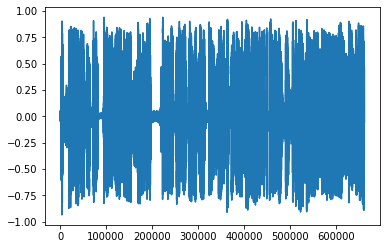

In [6]:
plt.plot(train_sounds[0])
plt.show()

In [7]:
fft_step=256
fft_size=512
fft_chunks = len(train_sounds[0])//fft_step

test_logmag = dft_logmag(test_sounds,fft_chunks,fft_step,fft_size)
train_logmag = dft_logmag(train_sounds,fft_chunks,fft_step,fft_size)
validate_logmag = dft_logmag(validate_sounds,fft_chunks,fft_step,fft_size)

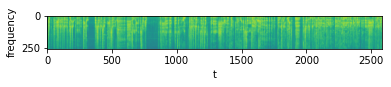

In [8]:
plt.imshow(train_logmag[0].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

In [9]:
patch_step = 32 #32
patch_size = 64 #64

def ds_window(sound, label, patch_step, patch_size):
    labels = np.ones(len(sound))*label
    sound = np.c_[sound,labels]
    ds = tf.data.Dataset.from_tensor_slices(sound)
    ds = ds.window(size=patch_size,shift=patch_step,drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(patch_size))
    return ds

def ds_patches(sounds, labels, patch_step, patch_size):
    ds = ds_window(sounds[0],labels[0],patch_step,patch_size)
    for sound, label in zip(sounds[1:],labels[1:]): ds = ds.concatenate(ds_window(sound,label,patch_step,patch_size))
    ds = ds.map(lambda x: (x[:,:-1], x[0,-1]))
    return ds

test_ds = ds_patches(test_logmag, test_labels, patch_step, patch_size)
train_ds = ds_patches(train_logmag, train_labels, patch_step, patch_size)
validate_ds = ds_patches(validate_logmag, validate_labels, patch_step, patch_size)

n_test = test_logmag.shape[0]*(((test_logmag.shape[1]-patch_size)//patch_step)+1)
n_train = train_logmag.shape[0]*(((train_logmag.shape[1]-patch_size)//patch_step)+1)
n_validate = validate_logmag.shape[0]*(((validate_logmag.shape[1]-patch_size)//patch_step)+1)

print(f"{n_test} samples for test.")
print(f"{n_train} samples for training.")
print(f"{n_validate} samples for validation.")
print(f"type of test_ds: {type(test_ds)}")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


1896 samples for test.
6478 samples for training.
1738 samples for validation.
type of test_ds: <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [10]:
n = 10
for sound, label in train_ds.take(n):
    sound = sound.numpy()
    print(f"{sound.shape} : {sound[[0,patch_step],0]} : {sound[[-patch_step-1,-1],0]}")

(64, 256) : [-6.47290116 -5.33082201] : [-4.67860369 -7.25374452]
(64, 256) : [-5.33082201 -5.34096172] : [-7.25374452 -5.6976597 ]
(64, 256) : [-5.34096172 -5.60514561] : [-5.6976597  -4.40980922]
(64, 256) : [-5.60514561 -6.13139182] : [-4.40980922 -4.38694182]
(64, 256) : [-6.13139182 -5.24542735] : [-4.38694182 -6.46717723]
(64, 256) : [-5.24542735 -5.17707933] : [-6.46717723 -5.07609914]
(64, 256) : [-5.17707933 -5.24986646] : [-5.07609914 -5.73956767]
(64, 256) : [-5.24986646 -5.22871348] : [-5.73956767 -4.19104213]
(64, 256) : [-5.22871348 -3.99726943] : [-4.19104213 -5.24307679]
(64, 256) : [-3.99726943 -4.74161242] : [-5.24307679 -5.03682569]


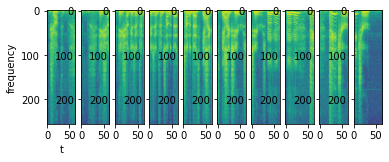

In [11]:
for i, (sound, label) in enumerate(train_ds.take(n)):
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy().T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
plt.show()

In [12]:
#Shuffle and batch datasets for use directly in model.fit
test_ds = test_ds.shuffle(n_test).batch(patch_size)
train_ds = train_ds.shuffle(n_train).batch(patch_size)
validate_ds = validate_ds.shuffle(n_validate).batch(patch_size)

# Create the models

##Model 1 - four convolutional layers, two fully connected

In [13]:
# Define the input shape of the images
input_shape = (64, 256, 1)

# Define the model architecture
model = tf.keras.Sequential([
    
    # First convolutional layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    # Second convolutional layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    # Third convolutional layer
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    # Fourth convolutional layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    # Flatten the output of the convolutional layers
    tf.keras.layers.Flatten(),
    
    # First fully connected layer
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    
    # Second fully connected layer
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 254, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 127, 32)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 127, 32)      128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 62, 64)       0         
 2D)                                                             
                                                        

In [14]:
#save_path = '../save/mnist_{epoch}.ckpt'
#save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

hist = model.fit(train_ds,
          epochs=20, batch_size=32, #epochs=5 
          validation_data=validate_ds)

Epoch 1/20
102/102 [==============================] - 18s 52ms/step - loss: 0.1498 - accuracy: 0.9504 - val_loss: 3.5339 - val_accuracy: 0.5000
Epoch 2/20
102/102 [==============================] - 7s 43ms/step - loss: 0.0533 - accuracy: 0.9819 - val_loss: 5.2938 - val_accuracy: 0.5282
Epoch 3/20
102/102 [==============================] - 6s 43ms/step - loss: 0.0415 - accuracy: 0.9860 - val_loss: 0.5066 - val_accuracy: 0.8516
Epoch 4/20
102/102 [==============================] - 6s 42ms/step - loss: 0.0407 - accuracy: 0.9858 - val_loss: 0.1614 - val_accuracy: 0.9425
Epoch 5/20
102/102 [==============================] - 6s 43ms/step - loss: 0.0143 - accuracy: 0.9952 - val_loss: 0.6265 - val_accuracy: 0.8205
Epoch 6/20
102/102 [==============================] - 6s 42ms/step - loss: 0.0179 - accuracy: 0.9931 - val_loss: 0.1866 - val_accuracy: 0.9338
Epoch 7/20
102/102 [==============================] - 6s 42ms/step - loss: 0.0438 - accuracy: 0.9853 - val_loss: 0.1444 - val_accuracy: 0.962

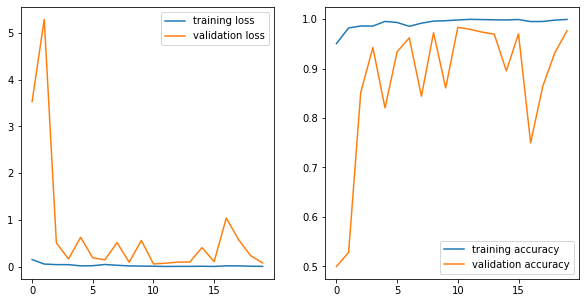

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

##Second model

In [16]:
# Define the model architecture
model2 = tf.keras.models.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', input_shape=input_shape),
    # Second convolutional layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu'),
    # Third convolutional layer
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu'),
    # Fourth convolutional layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu'),
    # Flatten the output of the convolutional layers
    tf.keras.layers.Flatten(),
    # First fully connected layer
    tf.keras.layers.Dense(units=512, activation='relu'),
    # Second fully connected layer (output layer)
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 31, 127, 32)       320       
                                                                 
 conv2d_5 (Conv2D)           (None, 15, 63, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 31, 128)        73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 15, 256)        295168    
                                                                 
 flatten_1 (Flatten)         (None, 11520)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               5898752   
                                                                 
 dense_3 (Dense)             (None, 1)                

In [17]:
save_path = '../save/mnist_{epoch}.ckpt'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

hist2 = model2.fit(train_ds,
          epochs=20, batch_size=32, 
          validation_data=validate_ds)

Epoch 1/20
102/102 [==============================] - 7s 26ms/step - loss: 0.6088 - accuracy: 0.7231 - val_loss: 0.3897 - val_accuracy: 0.8383
Epoch 2/20
102/102 [==============================] - 4s 22ms/step - loss: 0.2581 - accuracy: 0.9052 - val_loss: 0.1868 - val_accuracy: 0.9327
Epoch 3/20
102/102 [==============================] - 4s 23ms/step - loss: 0.1363 - accuracy: 0.9520 - val_loss: 0.2043 - val_accuracy: 0.9016
Epoch 4/20
102/102 [==============================] - 4s 23ms/step - loss: 0.1366 - accuracy: 0.9495 - val_loss: 0.1679 - val_accuracy: 0.9269
Epoch 5/20
102/102 [==============================] - 4s 23ms/step - loss: 0.0720 - accuracy: 0.9758 - val_loss: 0.1630 - val_accuracy: 0.9356
Epoch 6/20
102/102 [==============================] - 4s 22ms/step - loss: 0.0743 - accuracy: 0.9730 - val_loss: 0.1617 - val_accuracy: 0.9344
Epoch 7/20
102/102 [==============================] - 4s 23ms/step - loss: 0.0574 - accuracy: 0.9778 - val_loss: 0.1550 - val_accuracy: 0.9459

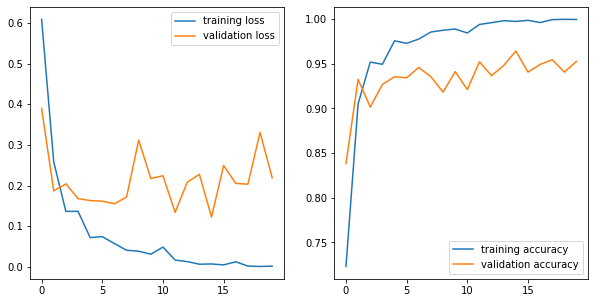

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist2.epoch, hist2.history['loss'])
axs[0].plot(hist2.epoch, hist2.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[1].plot(hist2.epoch, hist2.history['accuracy'])
axs[1].plot(hist2.epoch, hist2.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

# Explorations

In [19]:
test_x = test_ds.map(lambda x, y: x)

In [20]:
type(test_x)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [21]:
type(test_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset